In [207]:
# NOTES
# install deps
# conda activate birdenv
# pip install tensorflow-datasets
# pip install opencv-python

In [209]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import EarlyStopping

In [213]:
print("with bird:", len(os.listdir("dataset/with_bird")))
print("no bird:", len(os.listdir("dataset/no_bird")))

with bird: 732
no bird: 747


In [215]:
model_name="bird_detection_model_v3.2"

img_size = (180, 180)  # Resize target for all images
batch_size = 32        # Number of images loaded per training step

# ✅ Load your custom dataset from the 'dataset/' folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'  # ✅ for binary classification (0 or 1)
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

# ✅ Preprocessing
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
ds_val = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 1479 files belonging to 2 classes.
Using 1184 files for training.
Found 1479 files belonging to 2 classes.
Using 295 files for validation.


In [217]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch:", labels.numpy())


Image batch shape: (32, 180, 180, 3)
Label batch: [0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0]


In [219]:
# Data augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [221]:
# Build CNNN (Convolutional Neural Network) - test - bird

model = models.Sequential([
    layers.Input(shape=(180, 180, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # 👈 prevent overfitting
    layers.Dense(2, activation='softmax')  # either bird and no bird
])

In [223]:
# Create the callback
early_stop = EarlyStopping(
    monitor='val_accuracy',      # Monitor validation loss val_loss/val_accuracy
    patience=2,              # Stop training if no improvement after 2 epochs
    mode='max',
    restore_best_weights=True  # Revert to the best weights seen during training
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    # callbacks=[early_stop]  # 👈 Add the callback here
)

print(history.history)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5204 - loss: 0.8564 - val_accuracy: 0.4983 - val_loss: 0.6910
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.5513 - loss: 0.6878 - val_accuracy: 0.6136 - val_loss: 0.6908
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.5457 - loss: 0.6892 - val_accuracy: 0.5322 - val_loss: 0.6927
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.5404 - loss: 0.7019 - val_accuracy: 0.6136 - val_loss: 0.6637
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.5810 - loss: 0.6650 - val_accuracy: 0.6000 - val_loss: 0.6389
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6362 - loss: 0.6375 - val_accuracy: 0.5898 - val_loss: 0.6150
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.6117 - loss: 0.6291 - val_accuracy: 0.6237 - val_loss: 0.5960
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.6483 - loss: 0.6195 - val_accuracy: 0.6271 - 

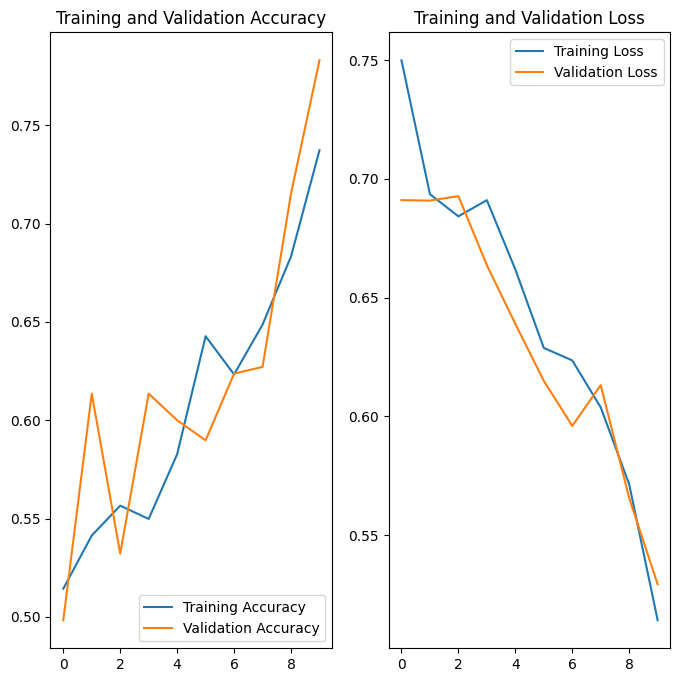

In [225]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [227]:
model.save(f"{model_name}.keras")

In [229]:
# Load the model from .keras file
model = tf.keras.models.load_model(f"{model_name}.keras")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite model
with open(f"{model_name}.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpb1a4e085\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpb1a4e085\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmpb1a4e085'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_layer_23')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1623947173504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623947175616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623947165760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623946521136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623946517088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623946515856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1624240418560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623947648288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623947651456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623947650752: TensorSpec(shape=(), dtype=tf.resource, name=None)
